In [1]:
import sys         
sys.path.append('./../')        

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from src.data.load_data import load_ptbxl_data
from biosppy.signals import ecg, ppg
from scipy.stats import skew, kurtosis
import plotly.express as px
TARGET = 'diagnostic_class'
DATASET_PATH = Path("./../data/sample")

In [444]:
from scipy.signal import savgol_filter, sosfiltfilt, butter, cheby2, firwin, filtfilt, iirnotch, freqz, welch, spectrogram, detrend
from scipy.fft import rfft, rfftfreq
from scipy.interpolate import interp1d
from statsmodels.tsa.seasonal import STL

class Signal:
    def __init__(self, name, data, fs):
        self.name = name
        self.data = data
        self.fs = fs
        self.n_samples = len(data)
        self.duration = self.n_samples / fs
        self.time = np.arange(0, self.n_samples) / fs

    def interpolate(self, fs, kind='cubic'):
        interp_fn = interp1d(self.time, self.data, kind=kind, fill_value='extrapolate')
        n_samples = int(self.n_samples * fs / self.fs)
        new_time = np.arange(0, n_samples) / fs
        new_time = new_time[(new_time >= self.time[0]) & (new_time <= self.time[-1])]
        interpolated = interp_fn(new_time)
        new_name = self.name + f"_interp({fs:.2f}Hz)"
        return Signal(new_name, interpolated, fs)
    
    def get_slice(self, start_time, end_time):
        mask = (self.time >= start_time) & (self.time <= end_time)
        new_name = self.name + f"_slice({start_time}-{end_time})"
        new_data = self.data[mask]
        return Signal(new_name, new_data, self.fs)
    
    def get_derivative(self, deriv=1, window_length=21, polyorder=5):
        new_name = self.name + f"_derivative({deriv})"
        new_data = savgol_filter(self.data, window_length, polyorder, deriv, delta = 1 / self.fs)
        return Signal(new_name, new_data, self.fs)
        
    def detrend(self):
        detrended = detrend(self.data)
        new_name = self.name + f"_detrended"
        return Signal(new_name, detrended, self.fs)
    
    def seasonal_decompose(self, plot=False):
        res = STL(self.data, period=self.fs).fit()
        if plot:
            res.plot()
        return res
    
    def get_cheby2_filtered(self, cutoff, btype='lowpass', order=4, rs=10):
        sos = cheby2(order, rs, cutoff, btype, output='sos', fs=self.fs)
        filtered = sosfiltfilt(sos, self.data)
        new_name = self.name + f"_{btype}_cheby2_filt({np.round(cutoff, 2)})"
        return Signal(new_name, filtered, self.fs)
    
    def get_fir_filtered(self, cutoff, btype='lowpass', numtaps=10):
        firf = firwin(numtaps, cutoff, pass_zero=btype, fs=self.fs)
        filtered = filtfilt(firf, 1, self.data)       
        new_name = self.name + f"{btype}_fir_filt({np.round(cutoff, 2)})"
        return Signal(new_name, filtered, self.fs)
    
    def get_notch_filtered(self, cutoff, Q=10):
        b, a = iirnotch(cutoff, Q=Q, fs=self.fs)
        filtered = filtfilt(b, a, self.data)
        new_name = self.name + f"_notch_filt({np.round(cutoff, 2)})"
        return Signal(new_name, filtered, self.fs)
    
    def fft(self, plot=False, ax=None):
        mags = rfft(self.data)
        freqs = rfftfreq(self.n_samples, 1 / self.fs)
        if plot:
            if ax is None:
                fig, ax = plt.subplots(figsize=(16, 8))
            ax.plot(freqs[1:], np.abs(mags[1:]))
        return freqs, mags
    
    def psd(self, window_size, min_hz=0, max_hz=10, plot=False, ax=None):
        freqs, pxx = welch(self.data, self.fs, nperseg=self.fs*window_size)
        if plot:
            if ax is None:
                fig, ax = plt.subplots(figsize=(16, 8))
            mask = (freqs >= min_hz) & (freqs <= max_hz)
            ax.plot(freqs[mask], pxx[mask], lw=2)
            ax.set_xlabel('Frequency [Hz]', fontsize=18) 
            ax.set_ylabel("Power Spectral Density", fontsize=18)

        return freqs, pxx
    
    def spectrogram(self, NFFT=256, noverlap=128, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(20, 8))
        spectrum, freqs, t, img = ax.specgram(self.data, Fs=self.fs, NFFT=NFFT, noverlap=noverlap)
        cbar = plt.gcf().colorbar(img)
        cbar.ax.set_title('Intensity', fontsize=14)
        ax.set_ylabel('Frequency [Hz]', fontsize=18) 
        ax.set_xlabel('Time [s]', fontsize=18)  
        return spectrum, freqs, t
    
    def extract_basic_features(self):
        basic_features = {
            "mean" : np.mean(self.data),
            "std" : np.std(self.data),
            "median": np.median(self.data),
            "skewness": skew(self.data),
            "kurtosis": kurtosis(self.data),
        }
        return basic_features
    
    def plot(self, start_time=0, width=10, scatter=False, line=True, first_der=False, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(18, 6))
        end_time = start_time + width
        signal_slice = self.get_slice(start_time, end_time)
        if scatter:
            sig_plot = ax.scatter(signal_slice.time, signal_slice.data, lw=3, label=signal_slice.name)
            plots = [sig_plot]
        if line:
            sig_plot = ax.plot(signal_slice.time, signal_slice.data, lw=3, label=signal_slice.name)
            plots = [sig_plot[0]]
        if first_der:
            ax2 = ax.twinx()
            signal_slice_der = signal_slice.get_derivative()
            if scatter:
                first_der_plot = ax2.scatter(signal_slice_der.time, signal_slice_der.data, c=sns.color_palette()[1], lw=1, label=signal_slice_der.name)
            if line:
                first_der_plot = ax2.plot(signal_slice_der.time, signal_slice_der.data, c=sns.color_palette()[1], lw=1, label=signal_slice_der.name)
            plots.append(first_der_plot[0])
            ax2.set_ylabel("First derivative values", fontsize=18)
            ax2.axhline(y = 0, c='black', ls='--', lw=0.5)
        labels = [plot.get_label() for plot in plots]
        ax.legend(plots, labels, loc=0, fontsize=18)
        ax.set_ylabel("Signal values", fontsize=18)
        ax.set_xlabel("Time [s]", fontsize=18)
        
     
    def explore(self, start_time, width=None, window_size=4, min_hz=0, max_hz=20):
        if width is None:
            width = self.time[-1] - start_time
            
        signal_slice = self.get_slice(start_time, start_time+width)
        fig = plt.figure(figsize=(40, 20), constrained_layout=True)
        spec = fig.add_gridspec(8, 8, wspace=.8, hspace=.8)

        ax00 = fig.add_subplot(spec[:4, :6])
        ax01 = fig.add_subplot(spec[:4, 6:])
        ax11 = fig.add_subplot(spec[4:, :4])
        ax12 = fig.add_subplot(spec[4:, 4:])

        signal_slice.plot(start_time, width, ax=ax00)
        sns.kdeplot(signal_slice.data, ax=ax01, lw=3)
        signal_slice.psd(window_size=window_size, min_hz=min_hz, max_hz=max_hz, plot=True, ax=ax11)
        signal_slice.spectrogram(ax=ax12)
        
        axes_params = [
            (ax00, "Signal"),
            (ax01, "Kernel Density Estimation"), 
            (ax11, "Power Spectral Density"), 
            (ax12, "Spectrogram")
        ]   
        
        for ax, title in axes_params:
            ax.set_title(title, fontsize=26,fontweight="bold")
            ax.tick_params(axis='both', which='major', labelsize=18)
            ax.margins(0.01)

/home/shate/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


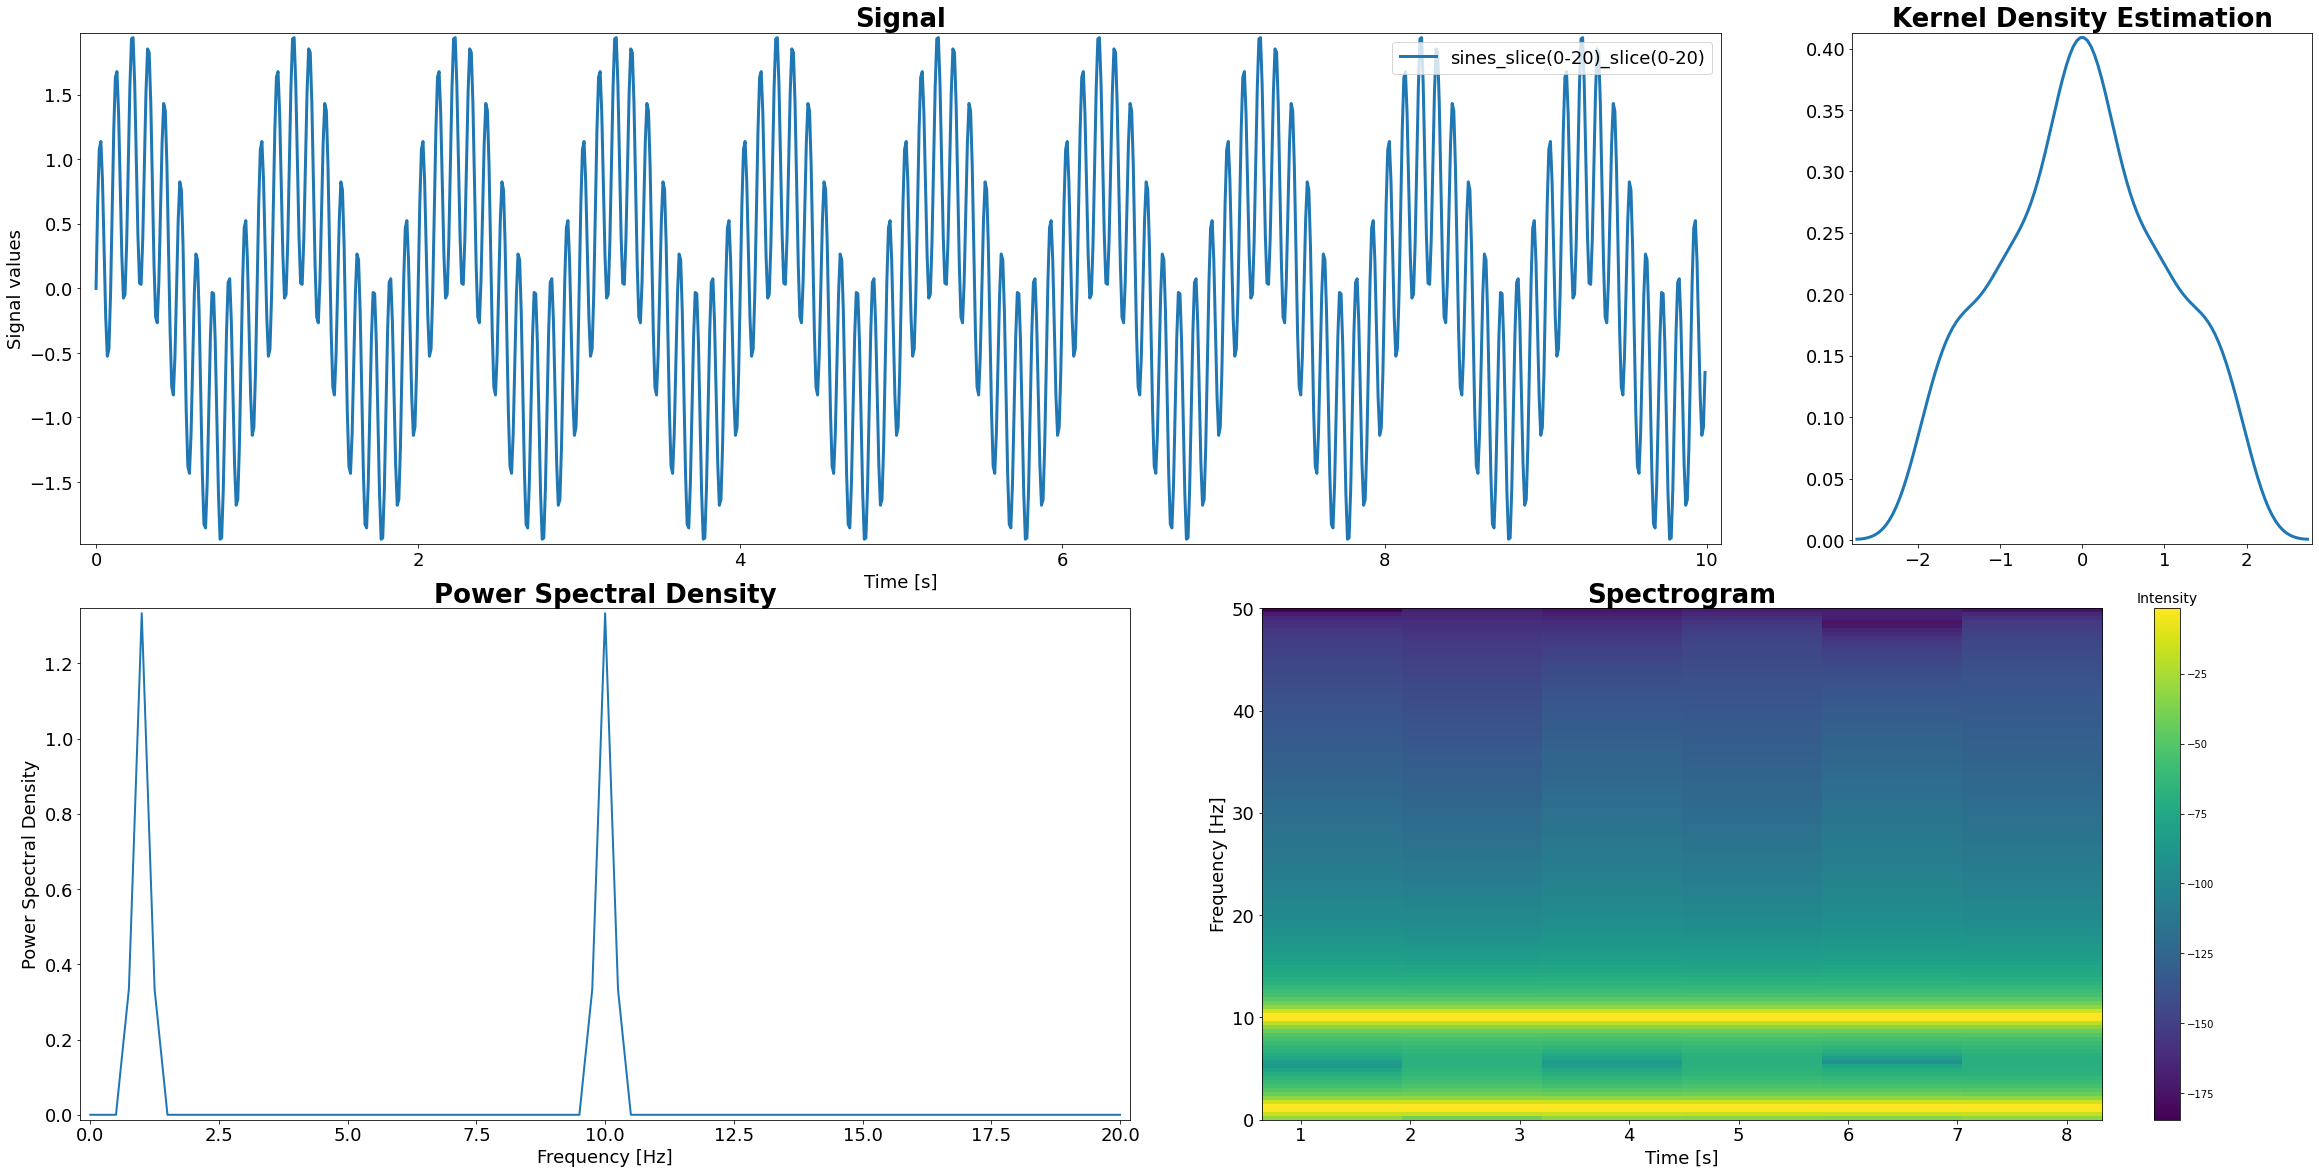

In [447]:
fs = 100
x = np.arange(0, 1000) / fs
y1 = np.sin(2*np.pi*1*x)
y2 = np.sin(2*np.pi*10*x)
signal = Signal('sines', y1 + y2, fs)
signal.explore(0, 20)

/home/shate/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


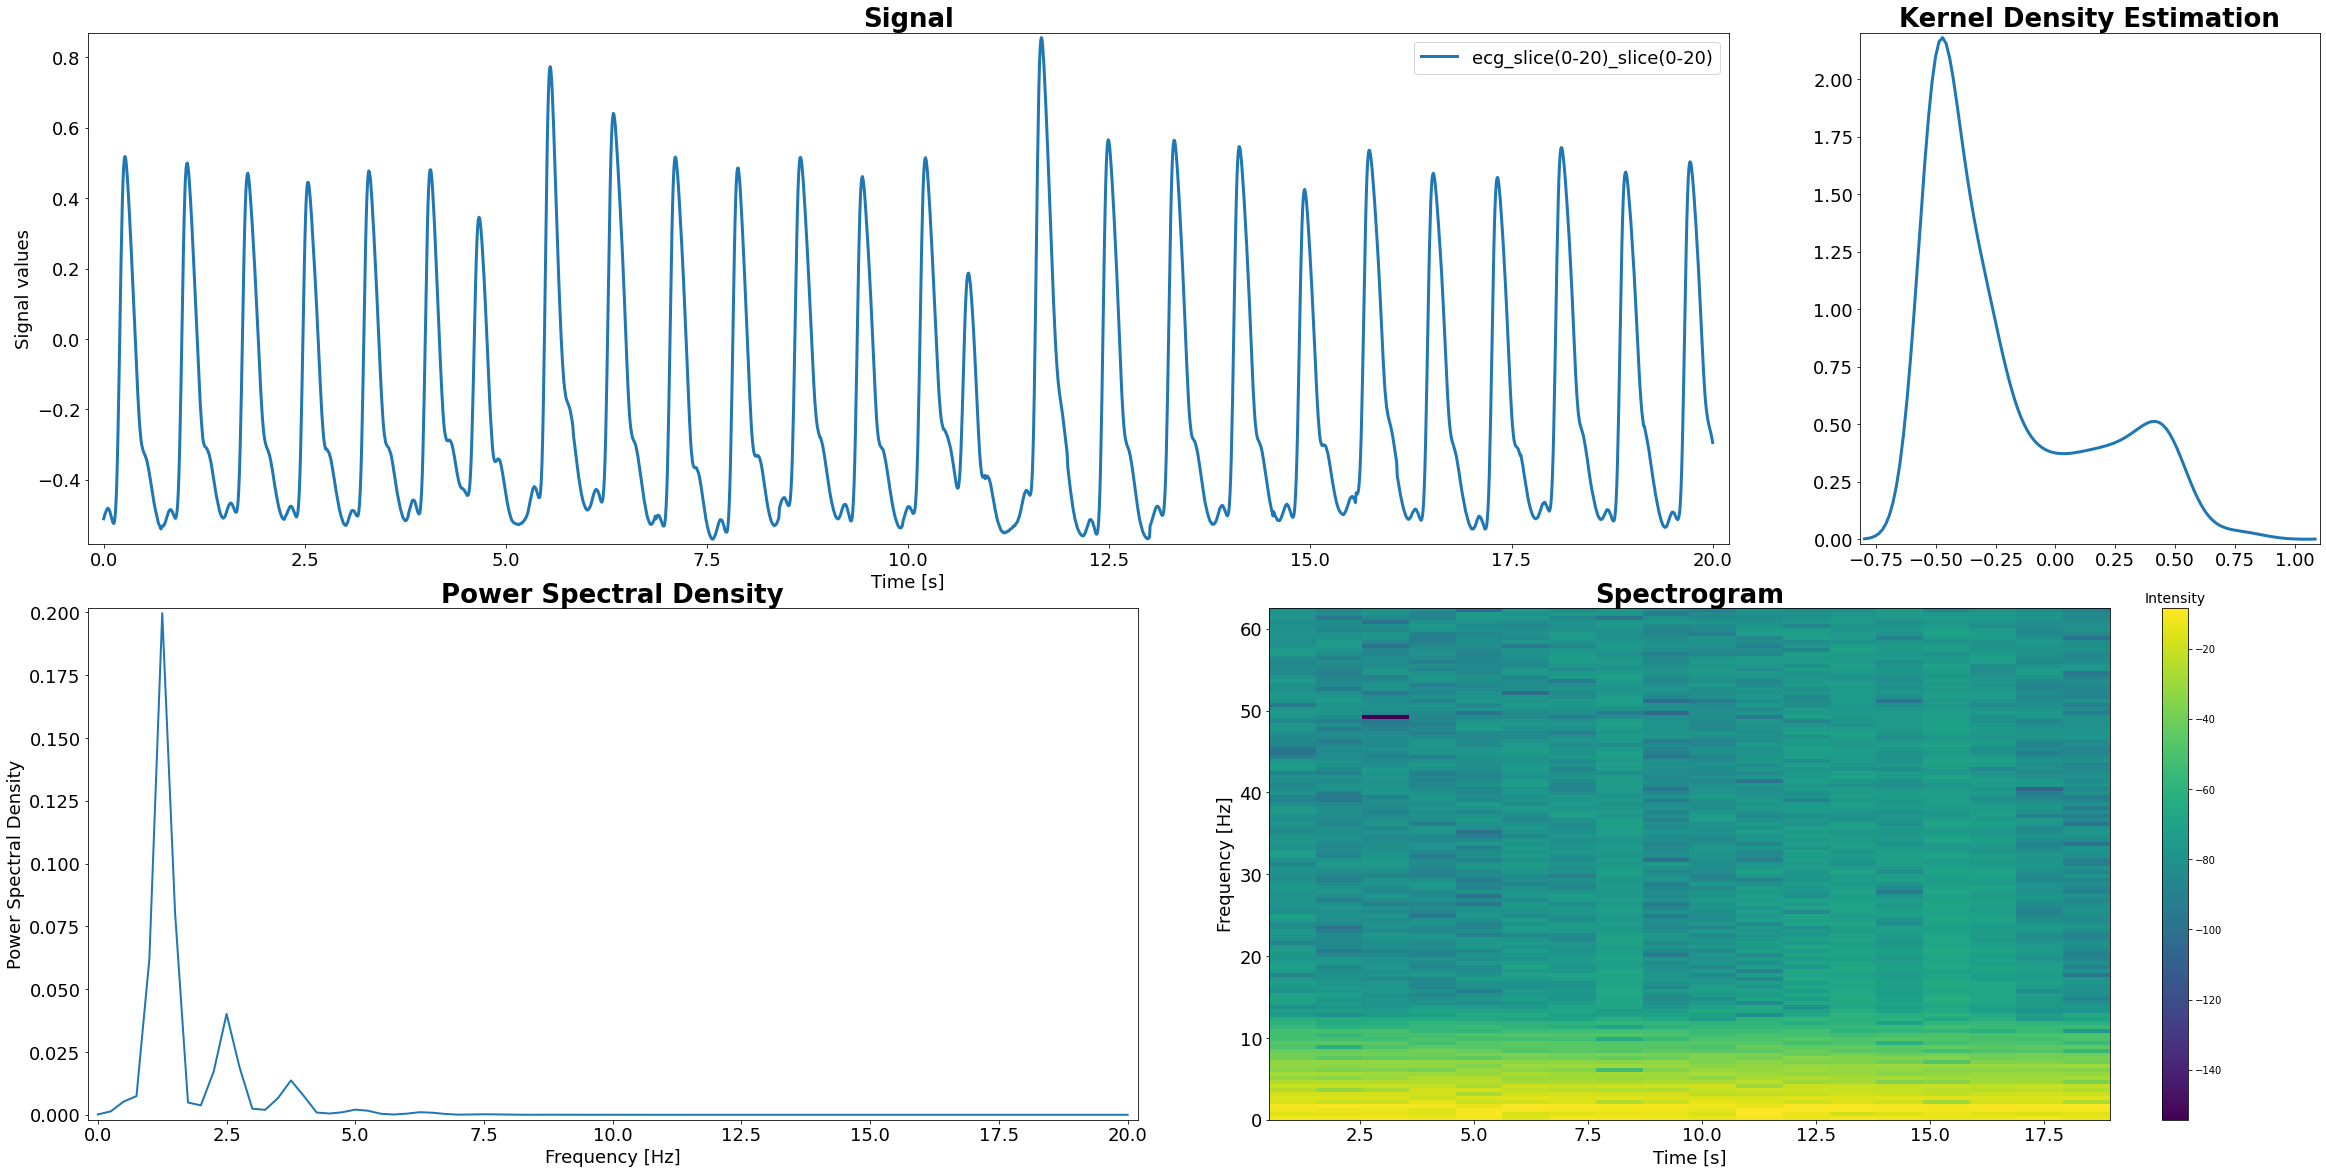

In [448]:
data = pd.read_csv(DATASET_PATH / "mimic.csv")
signal = Signal('ecg', data['PLETH'].values[20000:30000], 125)
signal.explore(0, 20)